In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
import re
import warnings
warnings.filterwarnings('ignore')


In [3]:
df = pd.read_csv(
    r"C:\Users\Kerem Gülser\Desktop\Dersler\Son Dönem\Natural Language Processing\english_dataset.tsv",
    sep="\t",
    encoding="utf-8"
)



In [ ]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5852 entries, 0 to 5851
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text_id  5852 non-null   object
 1   text     5852 non-null   object
 2   task_1   5852 non-null   object
 3   task_2   5852 non-null   object
 4   task_3   5852 non-null   object
dtypes: object(5)
memory usage: 228.7+ KB


text_id    0
text       0
task_1     0
task_2     0
task_3     0
dtype: int64

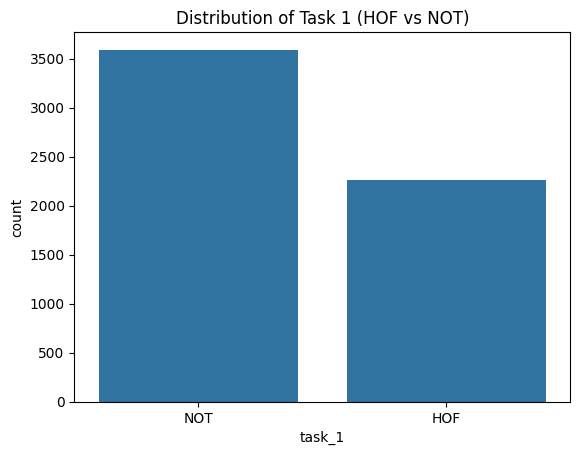

In [4]:
sns.countplot(x='task_1', data=df)
plt.title('Distribution of Task 1 (HOF vs NOT)')
plt.show()


In [5]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    return text.strip()

df['clean_text'] = df['text'].apply(clean_text)
df[['text', 'clean_text']].head()


,text,clean_text
0,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,dhonikeepstheglove watch sports minister kire...
1,@politico No. We should remember very clearly ...,no we should remember very clearly that indivi...
2,@cricketworldcup Guess who would be the winner...,guess who would be the winner of this cwc ...
3,Corbyn is too politically intellectual for #Bo...,corbyn is too politically intellectual for bor...
4,All the best to #TeamIndia for another swimmin...,all the best to teamindia for another swimming...


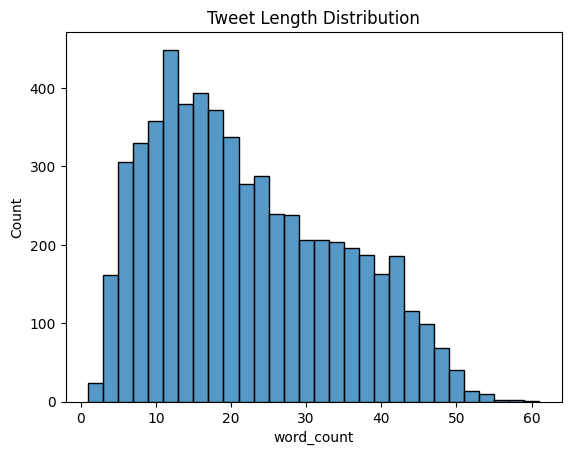

In [6]:
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))
sns.histplot(df['word_count'], bins=30)
plt.title('Tweet Length Distribution')
plt.show()


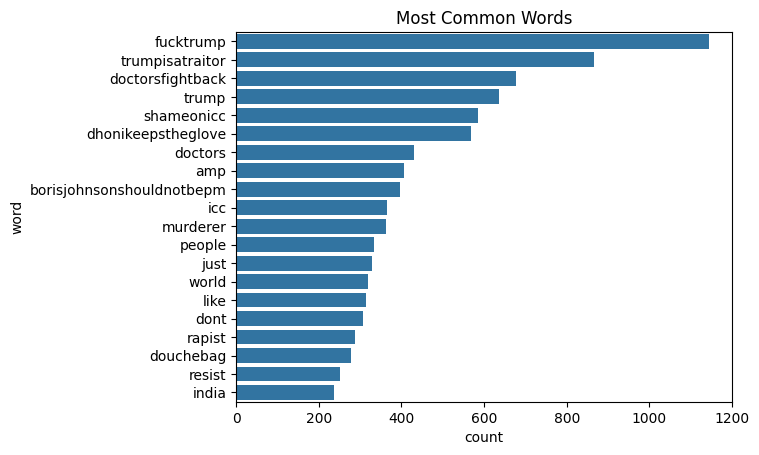

In [7]:
cv = CountVectorizer(stop_words='english', max_features=20)
X = cv.fit_transform(df['clean_text'])
words = cv.get_feature_names_out()
word_freq = X.toarray().sum(axis=0)

freq_df = pd.DataFrame({'word': words, 'count': word_freq}).sort_values(by='count', ascending=False)
sns.barplot(x='count', y='word', data=freq_df)
plt.title('Most Common Words')
plt.show()


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df["clean_text"]
y = df["task_1"]   # HOF vs NOT

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=300),
    "Naive Bayes": MultinomialNB(),
    "SVM (LinearSVC)": LinearSVC()
}

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    acc = round(accuracy_score(y_test, y_pred), 3)
    f1 = round(f1_score(y_test, y_pred, average="macro"), 3)

    print(f"\n{name}")
    print("Accuracy:", acc)
    print("F1-score:", f1)



Logistic Regression
Accuracy: 0.681
F1-score: 0.621

Naive Bayes
Accuracy: 0.676
F1-score: 0.612

SVM (LinearSVC)
Accuracy: 0.656
F1-score: 0.625


In [10]:
from sklearn.model_selection import GridSearchCV

param_grid_lr = {
    "C": [0.01, 0.1, 1, 5, 10],
    "penalty": ["l2"],
    "max_iter": [300, 500]
}

grid_lr = GridSearchCV(
    LogisticRegression(),
    param_grid_lr,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)

grid_lr.fit(X_train_tfidf, y_train)

print("Best LR Params:", grid_lr.best_params_)
print("Best LR Mean F1:", round(grid_lr.best_score_, 3))

best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_tfidf)

lr_optimized_acc = round(accuracy_score(y_test, y_pred_lr), 3)
lr_optimized_f1 = round(f1_score(y_test, y_pred_lr, average='macro'), 3)

print("Optimized LR Accuracy:", lr_optimized_acc)
print("Optimized LR F1:", lr_optimized_f1)


Best LR Params: {'C': 5, 'max_iter': 300, 'penalty': 'l2'}
Best LR Mean F1: 0.604
Optimized LR Accuracy: 0.658
Optimized LR F1: 0.62


In [11]:
param_grid_svm = {
    "C": [0.01, 0.1, 1, 5, 10]
}

grid_svm = GridSearchCV(
    LinearSVC(),
    param_grid_svm,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1
)

grid_svm.fit(X_train_tfidf, y_train)

print("Best SVM Params:", grid_svm.best_params_)
print("Best SVM Mean F1:", round(grid_svm.best_score_, 3))

best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test_tfidf)

svm_optimized_acc = round(accuracy_score(y_test, y_pred_svm), 3)
svm_optimized_f1 = round(f1_score(y_test, y_pred_svm, average='macro'), 3)

print("Optimized SVM Accuracy:", svm_optimized_acc)
print("Optimized SVM F1:", svm_optimized_f1)


Best SVM Params: {'C': 1}
Best SVM Mean F1: 0.596
Optimized SVM Accuracy: 0.656
Optimized SVM F1: 0.625


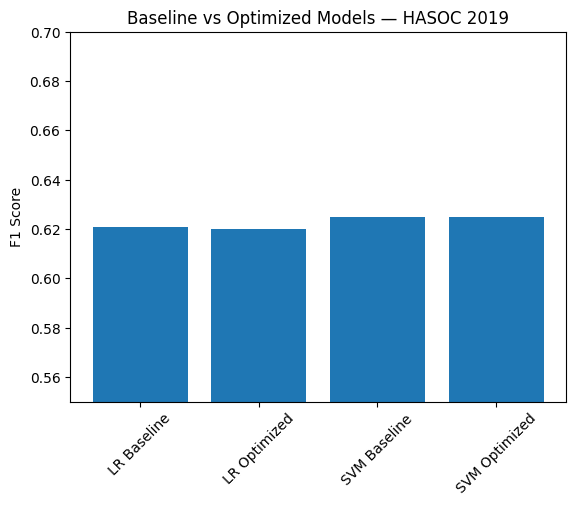

In [12]:
import matplotlib.pyplot as plt

models = [
    "LR Baseline", "LR Optimized",
    "SVM Baseline", "SVM Optimized"
]

scores = [
    0.621, 0.620,
    0.625, 0.625
]

plt.bar(models, scores)
plt.ylabel("F1 Score")
plt.title("Baseline vs Optimized Models — HASOC 2019")
plt.ylim(0.55, 0.70)
plt.xticks(rotation=45)
plt.show()
